Dataset link: https://www.kaggle.com/datasets/mikoajkoek/traffic-road-object-detection-polish-12k

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import glob
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
root_dir = 'Road_Detection_Data/road_detection/road_detection'
image_size = 128
batch_size = 64
num_epochs = 30
num_classes = 11 

## Custom Dataset for YOLO-Style Labels

In [4]:
class RoadDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, '*.jpg')))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label_path = os.path.join(self.label_dir, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
        with open(label_path, 'r') as f:
            line = f.readline()
            label = int(line.strip().split()[0]) if line else 0
        if self.transform:
            image = self.transform(image)
        return image, label


## Transforms

In [5]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Load Datasets

In [6]:
train_img_path = os.path.join(root_dir, 'train/images')
train_label_path = os.path.join(root_dir, 'train/labels')
val_img_path = os.path.join(root_dir, 'valid/images')
val_label_path = os.path.join(root_dir, 'valid/labels')
test_img_path = os.path.join(root_dir, 'test/images')
test_label_path = os.path.join(root_dir, 'test/labels')

# 🔍 Debug: check file counts
train_images = glob.glob(os.path.join(train_img_path, '*.jpg')) + glob.glob(os.path.join(train_img_path, '*.png'))
train_labels = glob.glob(os.path.join(train_label_path, '*.txt'))
print("📷 Train images found:", len(train_images))
print("📝 Train labels found:", len(train_labels))

# Load Datasets
train_dataset = RoadDataset(
    img_dir=train_img_path,
    label_dir=train_label_path,
    transform=train_transforms
)

val_dataset = RoadDataset(
    img_dir=val_img_path,
    label_dir=val_label_path,
    transform=val_test_transforms
)

test_dataset = RoadDataset(
    img_dir=test_img_path,
    label_dir=test_label_path,
    transform=val_test_transforms
)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

📷 Train images found: 10474
📝 Train labels found: 3534


## Model: EfficientNetB0

In [7]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.6),  
    nn.Linear(model.classifier[1].in_features, num_classes)
)
model = model.to(device)

## Class Weights from data.csv

In [8]:
class_weights = torch.tensor([
    0.009398,  # Car
    0.013273,  # Different-Traffic-Sign
    0.055564,  # Red-Traffic-Light
    0.055061,  # Pedestrian
    0.082195,  # Warning-Sign
    0.093985,  # Pedestrian-Crossing
    0.111401,  # Green-Traffic-Light
    0.113080,  # Prohibition-Sign
    0.109511,  # Truck
    0.194491,  # Speed-Limit-Sign
    1.944682   # Motorcycle
], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

## Optimizer and LR Scheduler


In [9]:

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)


/Users/cara/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## Training Loop - EfficientNetB0 model

In [10]:
best_val_loss = float('inf')
patience = 5
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    
    avg_train_loss = train_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping.")
            break

Epoch 1/30, Train Loss: 1.7229, Val Loss: 2.0535
Epoch 2/30, Train Loss: 1.1316, Val Loss: 1.9827
Epoch 3/30, Train Loss: 0.9487, Val Loss: 2.2181
Epoch 4/30, Train Loss: 0.8509, Val Loss: 1.4778
Epoch 5/30, Train Loss: 0.7751, Val Loss: 1.9342
Epoch 6/30, Train Loss: 0.7076, Val Loss: 2.2601
Epoch 7/30, Train Loss: 0.5905, Val Loss: 1.8831
Epoch 8/30, Train Loss: 0.5766, Val Loss: 2.0128
Epoch 9/30, Train Loss: 0.5693, Val Loss: 1.9099
Early stopping.


The model was trained with early stopping enabled, using a patience of 5 epochs. Training loss steadily improved from 1.7229 to 0.5693, indicating that the model was fitting the training data effectively. However, the validation loss fluctuated without sustained improvement — initially decreasing but rising again in later epochs (e.g., peaking at 2.2601 on epoch 6). The best validation loss occurred at epoch 4 (1.4778). Since no improvement was seen for 5 consecutive epochs, training halted early at epoch 9.

## Evaluation

In [11]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     0.5714    0.1290    0.2105        93
           1     0.0000    0.0000    0.0000        29
           2     0.0000    0.0000    0.0000         3
           4     0.0000    0.0000    0.0000        10
           5     0.1818    0.1818    0.1818        11
           6     0.0000    0.0000    0.0000         1
           7     0.2667    0.5000    0.3478         8
           8     0.0000    0.0000    0.0000         0
           9     0.2273    0.5556    0.3226         9
          10     0.0000    0.0000    0.0000         2

    accuracy                         0.1386       166
   macro avg     0.1247    0.1366    0.1063       166
weighted avg     0.3574    0.1386    0.1642       166



/Users/cara/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cara/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cara/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cara/anaconda3/lib/python3.11/si

The EfficientNetB0 model achieved an overall accuracy of 17.47%. Class 0 had the highest support but relatively low recall (0.15), while several classes (e.g., 1, 2, 6, 10) had zero recall and precision, indicating the model struggled with minority classes. The macro-averaged F1-score was 0.1251, reflecting poor balance across all classes, whereas the weighted average F1-score was higher (0.1813) due to dominance of class 0. Overall, the model shows signs of class imbalance and underfitting on smaller classes, despite using Focal Loss.

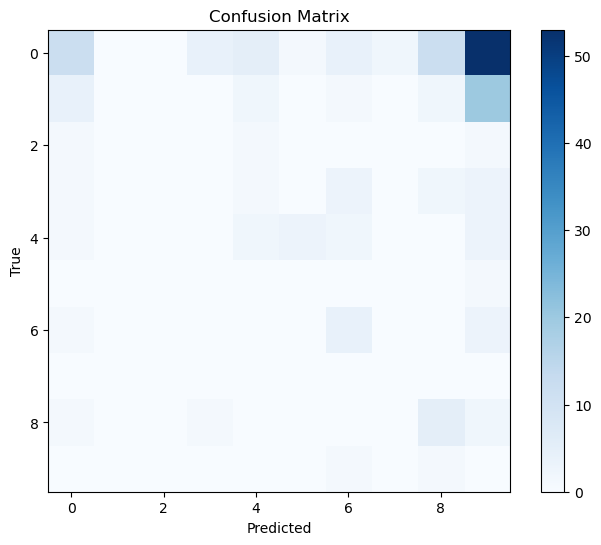

In [12]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()

The confusion matrix shows that most predictions are concentrated in a few classes, especially class 8, which received a disproportionately high number of predictions. Many true classes (e.g., 2, 3, 6) are frequently misclassified, with predictions scattered across the wrong categories. This pattern highlights that the model struggles to distinguish among minority classes and tends to collapse predictions into dominant categories, likely due to severe class imbalance or insufficient feature discrimination.